In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display, HTML
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from functions import pca_summary, printMeanAndSdByGroup, calclda, calcWithinGroupsVariance, groupStandardise, rpredict, calcBetweenGroupsVariance, calcSeparations

DISPLAY_MAX_ROWS = 20  # number of max rows to print for a DataFrame
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)

In [2]:
#Loading in the data
data = pd.read_csv('Concrete_Data.csv',sep=';')

#adjusting the names of the columns in the datatset
data.rename(columns={
    'Cement (component 1)(kg in a m^3 mixture)':'cement', 
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':'blast_furnace_slag',
    'Fly Ash (component 3)(kg in a m^3 mixture)':'fly_ash', 
    'Water  (component 4)(kg in a m^3 mixture)':'water', 
    'Superplasticizer (component 5)(kg in a m^3 mixture)':'superplasticizer',
    'Coarse Aggregate  (component 6)(kg in a m^3 mixture)':'coarse_aggregate', 
    'Fine Aggregate (component 7)(kg in a m^3 mixture)':'fine_aggregate', 
    'Age (day)':'age', 
    'Concrete compressive strength(MPa, megapascals) ':'compressive_strength'
}, inplace=True)

data.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
Y = data.compressive_strength #dependant variable
X = data.loc[:,:"age"] #independant variables

X

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


In [4]:
compressive_str25 = 23.710
compressive_str50 = 34.445
compressive_str75 = 46.135
Y.describe().T


count    1030.000000
mean       35.817961
std        16.705742
min         2.330000
25%        23.710000
50%        34.445000
75%        46.135000
max        82.600000
Name: compressive_strength, dtype: float64

In [5]:
Y_labeled = []

for var in Y:  # Label the data according to compressive strength
    if var > compressive_str75:
        Y_labeled.append("Strong")
    elif compressive_str75 > var > compressive_str25:
        Y_labeled.append("Average")
    elif var < compressive_str25:
        Y_labeled.append("Weak")

Scaling the data

In [6]:
scaler = StandardScaler().fit(X) #Initialize a StandardScaler instance and fit it to the dataset X
standardisedX = scaler.transform(X) # Apply the scaler to the data (standardize the features in X) 
standardisedX = pd.DataFrame(standardisedX, columns=X.columns)#Convert the scaled data back into a dataframe of the same structure
standardisedX

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,0.863154,-1.217670,-0.279733
1,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,1.056164,-1.217670,-0.279733
2,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,3.553066
3,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,5.057677
4,-0.790459,0.678408,-0.847144,0.488793,-1.039143,0.070527,0.647884,4.978487
...,...,...,...,...,...,...,...,...
1025,-0.045645,0.488235,0.564545,-0.092171,0.451410,-1.323005,-0.065893,-0.279733
1026,0.392819,-0.856888,0.960068,0.676200,0.702626,-1.994680,0.496893,-0.279733
1027,-1.270088,0.759579,0.850635,0.521589,-0.017528,-1.036064,0.080107,-0.279733
1028,-1.168610,1.308065,-0.847144,-0.279579,0.853356,0.214641,0.191166,-0.279733


PCA

In [7]:
pca = PCA().fit(standardisedX)
summary = pca_summary(pca, standardisedX)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,1.510000,0.285012,0.285012
PC2,1.189989,0.177009,0.462022
PC3,1.157618,0.167510,0.629532
PC4,1.007055,0.126770,0.756302
PC5,0.975453,0.118938,0.875240
PC6,0.888929,0.098774,0.974014
PC7,0.421713,0.022230,0.996245
PC8,0.173329,0.003755,1.000000


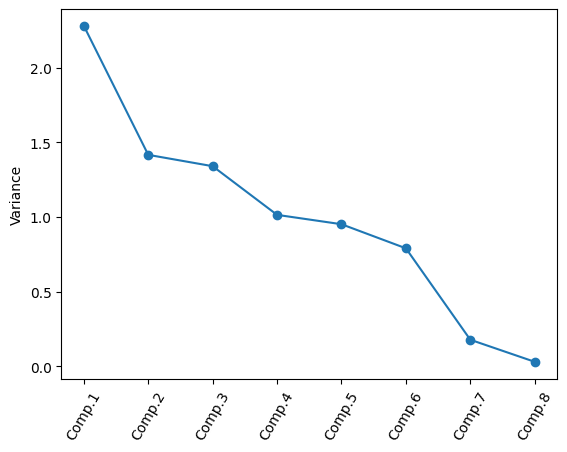

In [8]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, standardisedX)

### Loadings for the Principal Components

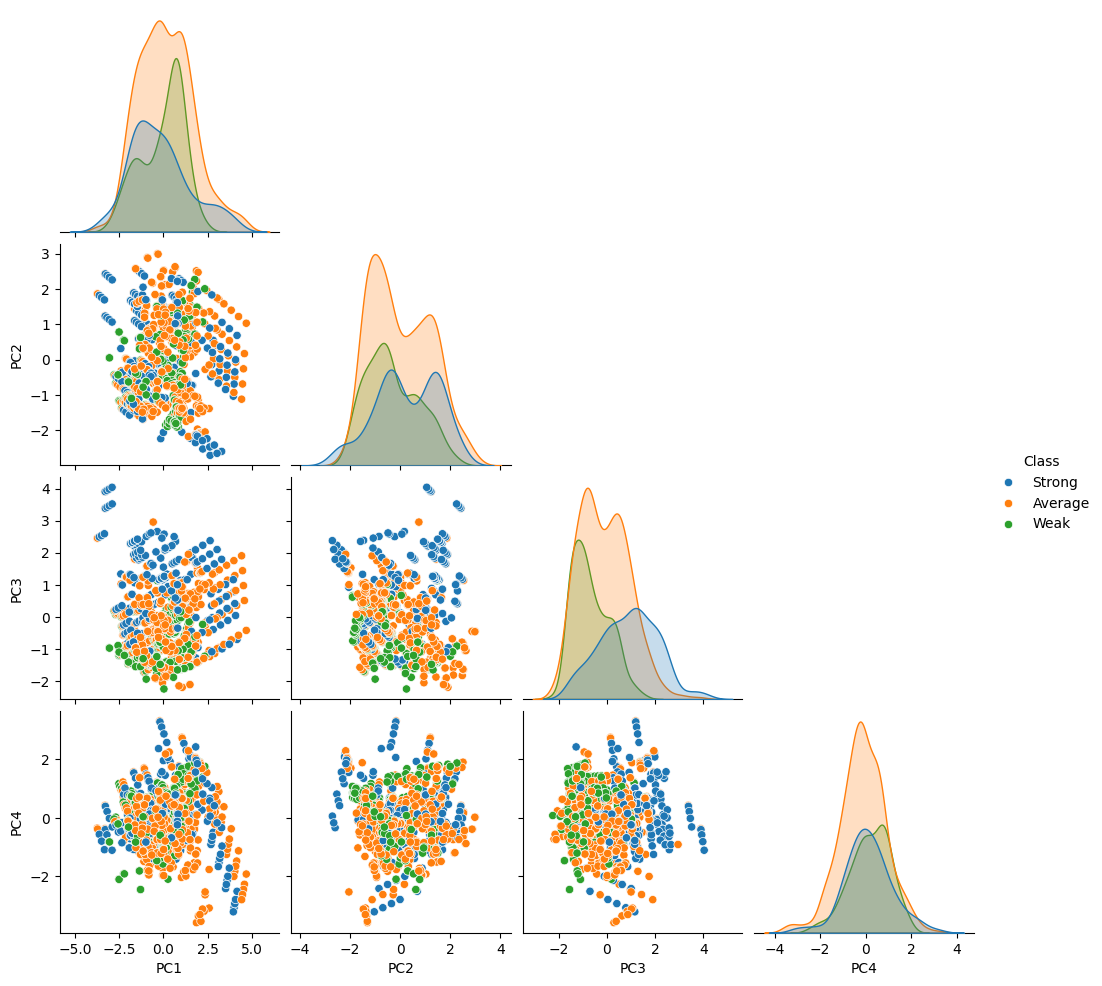

In [9]:
def pca_pairplot(pca, standardised_values, classifs):
    # Transform the standardized data using PCA
    foo = pca.transform(standardised_values)
    
    # Create a DataFrame with the first 4 principal components
    bar = pd.DataFrame({
        "PC1": foo[:, 0],
        "PC2": foo[:, 1],
        "PC3": foo[:, 2],
        "PC4": foo[:, 3],
        "Class": classifs
    })
    
    # Create a pairplot of the first 4 principal components with class as hue
    sns.pairplot(data=bar, vars=["PC1", "PC2", "PC3", "PC4"], hue="Class", diag_kind="kde", corner=True)
    
pca_pairplot(pca, standardisedX, Y_labeled)

#### PC1

In [10]:
pca.components_[0]

array([ 0.09840137,  0.17726197, -0.39466185,  0.54700395, -0.50594541,
        0.03792808, -0.40192597,  0.29147949])

Positive: (cement:0.098), (blast_furnace_slag:0.177), (water:0.547), (coarse_aggregate:0.03792808), (age:0.29147949)

Negative: (fly_ash:-0.394), (superplasticizer:-0.506), (fine_aggregate:-0.4019)

Dominated by **Water** with a strong positive contribution (0.547), indicating that water content significantly influences variance in PC1.
Negative influences from **Superplasticizer**, **Fine Aggregate**, and **Fly Ash**, which reduce the variance in PC1.

#### PC2

In [11]:
pca.components_[1]

array([-0.11373709,  0.6860529 , -0.14294751,  0.05325628,  0.2829296 ,
       -0.62994342, -0.01939111, -0.12598089])

Positive: ('blast_furnace_slag':0.6860529), ('water':0.05325628), (superplasticizer:0.2829296)

Negative: ('cement':-0.11373709), ('fly_ash':-0.14294751),('coarse_aggregate':-0.62994342), ('fine_aggregate':-0.01939111), ('age':-0.12598089)

Strong positive contribution from Blast Furnace Slag (0.686).
Negative contribution from Coarse Aggregate (-0.630), suggesting an inverse relationship in PC2 between these materials.

#### PC3

In [12]:
pca.components_[2]

array([ 0.81420224, -0.17179437, -0.40822055, -0.21318975,  0.23459653,
       -0.17408781, -0.00456921,  0.10052137])

Positive:
('cement':0.81420224), ('superplasticizer':0.23459653), ('age':0.10052137)

Negative:
('blast_furnace_slag':-0.17179437), ('fly_ash':-0.40822055), ('water':-0.21318975), ('coarse_aggregate':-0.17408781), ('fine_aggregate':-0.00456921)

Primarily driven by **Cement** (0.814), indicating cement content is a key descriptor here.
**Fly Ash** plays a counterbalancing role with a negative contribution (-0.408).

#### PC4

In [13]:
pca.components_[3]

array([ 0.054297  ,  0.36269932, -0.2267512 , -0.29606003,  0.03727351,
        0.54580513, -0.38528206, -0.52791909])

Positive:
('cement':0.054297), ('blast_furnace_slag':0.36269932), ('superplasticizer':0.03727351), ('coarse_aggregate':0.54580513)

Negative:
('fly_ash':-0.2267512), ('water':-0.29606003), ('fine_aggregate':-0.38528206), ('age':-0.52791909)

Strong contributions from **Age** (0.528) and **Fine Aggregate** (0.385), with **Coarse Aggregate** having a strong negative influence (-0.546), suggesting a balancing effect between these properties.

In [14]:
printMeanAndSdByGroup(standardisedX, Y_labeled);

## Means:


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
Average,-0.072344,-0.000759,0.068315,0.157448,-0.076178,-0.085155,-0.058171,0.084849
Strong,0.689751,0.178351,-0.180722,-0.486653,0.545015,-0.157584,-0.172547,0.355506
Weak,-0.545624,-0.176838,0.044622,0.172978,-0.393250,0.327235,0.288437,-0.524547



## Standard deviations:


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
Average,0.935708,1.026321,0.980589,0.997680,0.893080,0.955511,1.025854,1.102344
Strong,0.980753,0.919373,0.921035,1.091784,1.130612,1.103781,1.060052,1.060216
Weak,0.715035,0.998318,1.093613,0.715235,0.819980,0.905575,0.814394,0.201575



## Sample sizes:


,0
Average,514
Strong,258
Weak,258


In [15]:
# Function to create PCA scatter plots for all combinations of PC1-PC4
def pca_scatter_all_combinations(pca, standardised_values, classifs):
    # Perform PCA transformation
    foo = pca.transform(standardised_values)
    # Define the combinations of principal components
    combinations = [("PC1", "PC2"), ("PC1", "PC3"), ("PC1", "PC4"), 
                    ("PC2", "PC3"), ("PC2", "PC4"), ("PC3", "PC4")]
    # Loop through each combination and generate scatter plots
    for x_pc, y_pc in combinations:
        # Extract the corresponding principal components
        pc_x_idx = int(x_pc[2]) - 1  # Adjust to 0-indexing
        pc_y_idx = int(y_pc[2]) - 1
        # Create a dataframe for plotting
        bar = pd.DataFrame(zip(foo[:, pc_x_idx], foo[:, pc_y_idx], classifs), 
                           columns=[x_pc, y_pc, "Class"])
        # Create the scatter plot
        sns.lmplot(data=bar, x=x_pc, y=y_pc, hue="Class", fit_reg=False, legend_out=True)
        # Set the title for the plot
        plt.title(f"{x_pc} vs {y_pc}")
        # Adjust layout to avoid clipping
        # Save the plot to the "figures" directory
        plt.savefig(f"figures/{x_pc}_vs_{y_pc}.png")
        # Close the plot to avoid overwriting in the loop
        plt.close()

# Call the function
pca_scatter_all_combinations(pca, standardisedX, Y_labeled)


/home/oscartq/miniconda3/envs/dhenv/lib/python3.10/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/oscartq/miniconda3/envs/dhenv/lib/python3.10/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/oscartq/miniconda3/envs/dhenv/lib/python3.10/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/oscartq/miniconda3/envs/dhenv/lib/python3.10/site-packages/seaborn/regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings

## LDA